In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
import os

os.environ["NUMBA_CUDA_DRIVER"] = "/usr/lib/wsl/lib/libcuda.so.1"

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve

import random
from deap import base, creator, tools, algorithms

from sklearn.svm import SVC as skSVC
from cuml.svm import LinearSVC as cuSVC
from sklearn.linear_model import LogisticRegression as skLR
from sklearn.neighbors import KNeighborsClassifier as skKNN
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.naive_bayes import GaussianNB as skNB

from joblib import Parallel, delayed, load, dump

from collections import defaultdict
import time
import gc

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# setting individual creator
creator.create('FitnessMulti', base.Fitness, weights=(1, -1))
creator.create('Individual', list, fitness=creator.FitnessMulti)

def has_converged(series, w, eps):
    if w >= len(series):
        return False

    current = series[len(series)-1]
    window = series[-w-1:-1]
    average_error = np.mean(np.abs(window-current)/np.abs(current))
    return average_error <= eps

def evaluate(individual, model, X, y, gamma, r_eps, r_w, s_eps, s_w):
    n = len(X)
    b = round(n**gamma)
    subset_scores = []
    start_time = time.time()
    while not has_converged(subset_scores, s_w, s_eps) and not time.time() - start_time > 60:
        subsample_idx = random.sample(range(n), b)
        X_sampled = X[subsample_idx, :][:, individual]
        y_sampled = y[subsample_idx]
        train, test = train_test_split(np.arange(b), test_size=0.33, stratify=y_sampled, random_state=42)
        monte_carlo_scores = []
        while not has_converged(monte_carlo_scores, r_w, r_eps) and not time.time() - start_time > 60:
            sample_weights = np.random.multinomial(n=n, pvals=[1/b]*b, size=1)[0]
            clf = clone(model)
            clf.fit(X=X_sampled[train, :], 
                    y=y_sampled[train], 
                    sample_weight=sample_weights[train])
            monte_carlo_scores.append(
                roc_auc_score(y_sampled[test], 
                       clf.predict_proba(X_sampled[test, :])[:, 1],
                       sample_weight=sample_weights[test])
            )
        subset_scores.append(np.mean(monte_carlo_scores))
    return np.mean(subset_scores), np.count_nonzero(individual)

class GATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):   
        self.model = model
    
    def fit(self, X, y=None):
        # memmapping for later
        X_path = "cache/X_memmap.mmap"
        if os.path.exists(X_path): os.unlink(X_path)
        y_path = "cache/y_memmap.mmap"
        if os.path.exists(y_path): os.unlink(y_path)
        dump(X, X_path)
        dump(y, y_path)

        del X, y
        gc.collect()

        X_memmap = load(X_path, mmap_mode="r+")
        y_memmap = load(y_path, mmap_mode="r+")

        toolbox = base.Toolbox()
        
        n_features = X_memmap.shape[1]
        toolbox.register('attr_bool', random.choice, [True, False])
        toolbox.register(
            'individual', tools.initRepeat, creator.Individual,
            toolbox.attr_bool, n=n_features)
        toolbox.register(
            'population', tools.initRepeat, list, toolbox.individual)

        # raise population
        pop = toolbox.population(10)

        toolbox.register('mate', tools.cxTwoPoint)
        toolbox.register('mutate', tools.mutFlipBit, indpb=0.25)
        toolbox.register('evaluate', evaluate, model=self.model, 
                         gamma=0.64, r_eps = 0.04, r_w = 20, s_eps = 0.025, s_w = 5)
        toolbox.register('select', tools.selNSGA2)
        
        perf_stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
        n_feat_stats = tools.Statistics(key=lambda ind: ind.fitness.values[1])
        mstats = tools.MultiStatistics(perf=perf_stats, n_features=n_feat_stats)
        mstats.register("mean", np.mean)
        mstats.register("max", max)
        mstats.register("min", min)

        hof = tools.HallOfFame(3)

        mu = 12
        lambda_ = 30
        cxpb = 0.5
        mutpb = 0.5
        ngen = 50

        logbook = tools.Logbook()
        logbook.header = ['gen', 'nevals'] + mstats.fields

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in pop if not ind.fitness.valid]
        fitnesses = Parallel(n_jobs=4, max_nbytes=None)(
            delayed(toolbox.evaluate)(list(ind), X=X_memmap, y=y_memmap) for ind in invalid_ind
        )
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        hof.update(pop)

        # no real selecting, only to assign crowding distance
        pop = toolbox.select(pop, len(pop))

        record = mstats.compile(pop)
        logbook.record(gen=0, nevals=len(invalid_ind), **record)
        print(logbook.stream)

        with Parallel(n_jobs=4, max_nbytes=None) as parallel:
            for gen in range(1, ngen+1):
                offspring = algorithms.varOr(pop, toolbox, lambda_, cxpb, mutpb)

                # Evaluate the individuals with an invalid fitness
                invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
                fitnesses = parallel(delayed(toolbox.evaluate)
                                     (list(ind), X=X_memmap, y=y_memmap) for ind in invalid_ind)
                for ind, fit in zip(invalid_ind, fitnesses):
                    ind.fitness.values = fit
                
                hof.update(pop)

                # Select the next generation population
                pop[:] = toolbox.select(pop + offspring, mu)

                record = mstats.compile(pop)
                logbook.record(gen=gen, nevals=len(invalid_ind), **record)
                print(logbook.stream)
        
        self.logbook = logbook

        fig, ax1 = plt.subplots()

        ax1.set_xlabel('Number of generations')
        ax1.set_ylabel('Performance')
        ax1.plot(logbook.chapters['perf'].select("gen"), logbook.chapters['perf'].select("max"), label="Max Perf")

        ax2 = ax1.twinx()
        ax2.set_ylabel('Number of features')
        ax2.plot(logbook.chapters['n_features'].select("gen"), logbook.chapters['n_features'].select("min"), label="Min features")

        fig.suptitle(f'GA Transformer Evolution: {type(self.model).__name__}')
        fig.legend()
        fig.tight_layout()
        
        plt.show()
        
        self.best_features = hof[0]
        return self
    
    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return [name for name, selected in zip(input_features, self.best_features) if selected]
        else:
            return [name for name, selected in zip(self.feature_names_in_, self.best_features) if selected]
        
    def transform(self, X, y=None):
        return X[:, self.best_features]
    
    def get_logbook(self):
        return self.logbook
    
    def get_params(self, deep=True):
        return {"model": self.model}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [3]:
train_df = pd.read_parquet("data/DoHBrw/binary_train.parquet")
X_train = train_df.drop(['traffic_type'], axis=1)
y_train = train_df['traffic_type'].cat.codes.to_numpy()
print(f"X_train shape is {X_train.shape}")
del train_df

test_df = pd.read_parquet("data/DoHBrw/binary_test.parquet")
X_test = test_df.drop(['traffic_type'], axis=1)
y_test = test_df['traffic_type'].cat.codes.to_numpy()
print(f"X_test shape is {X_test.shape}")
del test_df

X_train shape is (923229, 34)
X_test shape is (231849, 34)


In [4]:
def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    precision, recall, f1_score, support = precision_recall_fscore_support(y, y_pred, average=None, zero_division=1)
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=0)
    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "support": support,
        "roc_auc_score": roc_auc_score(y, clf.predict_proba(X)[:, 1]),
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds
    }

fitting GA now
   	      	              n_features              	                         perf                         
   	      	--------------------------------------	------------------------------------------------------
gen	nevals	gen	max	mean	min	nevals	gen	max     	mean    	min    	nevals
0  	10    	0  	21 	17  	10 	10    	0  	0.999754	0.988114	0.89252	10    
1  	30    	1  	20 	15.25	10 	30    	1  	0.999861	0.985268	0.89252	30    
2  	30    	2  	20 	13.4167	10 	30    	2  	0.999861	0.990722	0.89252	30    
3  	30    	3  	20 	13.4167	10 	30    	3  	0.999861	0.990494	0.89252	30    
4  	30    	4  	20 	13.3333	9  	30    	4  	0.999861	0.999584	0.998301	30    
5  	30    	5  	20 	11.75  	7  	30    	5  	0.999861	0.994605	0.940212	30    
6  	30    	6  	20 	10.8333	7  	30    	6  	0.999861	0.999585	0.99777 	30    
7  	30    	7  	20 	10.3333	7  	30    	7  	0.999902	0.999606	0.99777 	30    
8  	30    	8  	20 	9.91667	7  	30    	8  	0.999903	0.999803	0.999587	30    
9  	30    	9  	20 	9.33333	7

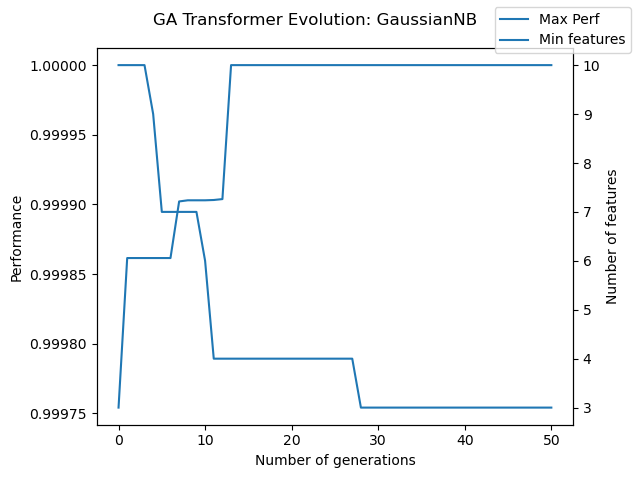

Took 297.550005197525 seconds to fit GA
fitting models with FS now
-------------------------------
Starting fit with GA selection for GaussianNB()
-------------------------------
-------------------------------
Results for GaussianNB() with GA selection: 
{'accuracy': 0.999443603379786, 'precision': array([0.9999505, 0.9976023]), 'recall': array([0.99934034, 0.99981977]), 'f1_score': array([0.99964532, 0.99870981]), 'support': array([181912,  49937]), 'roc_auc_score': 0.9995965426904498, 'fpr': array([0.        , 0.99981977, 1.        ]), 'tpr': array([0.00000000e+00, 6.59659616e-04, 1.00000000e+00]), 'thresholds': array([inf,  1.,  0.]), 'model': 'GaussianNB', 'n_features': 6, 'feature_names': ['SourceIP', 'DestinationIP', 'FlowReceivedRate', 'PacketLengthMode', 'PacketLengthSkewFromMode', 'ResponseTimeTimeSkewFromMode'], 'time': 0.24047088623046875}
Took 0.24047088623046875 seconds
-------------------------------
-------------------------------
Starting fit with GA selection for Rand

In [5]:
models = [skNB(), 
          skRF(n_estimators = 500),
          skLR(max_iter=5000),
          cuSVC(probability=True),
          skKNN(n_neighbors=17, algorithm="kd_tree")]
results = defaultdict(list)

print("fitting GA now")
start = time.time()
transform_pipe = make_pipeline(StandardScaler(), GATransformer(model=skNB()))
transform_pipe.fit(X_train, y_train)
end = time.time()
print(f"Took {end - start} seconds to fit GA")

results['logbook'] = transform_pipe['gatransformer'].get_logbook()

X_train_selected = transform_pipe.transform(X_train)
X_test_selected = transform_pipe.transform(X_test)

print("fitting models with FS now")

for model in models:
    print("-------------------------------")
    print(f"Starting fit with GA selection for {model}")
    print("-------------------------------")
    start = time.time()
    clf = clone(model)
    clf.fit(X_train_selected, y_train)
    scores = custom_scorer(clf, X_test_selected, y_test)
    end = time.time()
    scores['model'] = type(model).__name__
    scores['n_features'] = X_train_selected.shape[1]
    scores['feature_names'] = transform_pipe['gatransformer'].get_feature_names_out(input_features=X_train.columns.values)
    scores['time'] = end - start
    print("-------------------------------")
    print(f"Results for {model} with GA selection: ")
    print(scores)
    print(f"Took {end - start} seconds")
    print("-------------------------------")
    results['fs_scores'].append(scores)

print("fitting models without FS now")

X_train_scaled = transform_pipe[0].transform(X_train)
X_test_scaled = transform_pipe[0].transform(X_test)

for model in models:
    print("-------------------------------")
    print(f"Starting fit for {model}")
    print("-------------------------------")
    start = time.time()
    clf = clone(model)
    clf.fit(X_train_scaled, y_train)
    scores = custom_scorer(clf, X_test_scaled, y_test)
    end = time.time()
    scores['model'] = type(model).__name__
    scores['n_features'] = X_train.shape[1]
    scores['feature_names'] = X_train.columns.values
    scores['time'] = end - start
    print("-------------------------------")
    print(f"Results for {model} with GA selection: ")
    print(scores)
    print(f"Took {end - start} seconds")
    print("-------------------------------")
    results['no_fs_scores'].append(scores)

In [6]:
with open('dohbrw_results_blb_no_cv_binary_revised.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)